In [41]:
import os
import random
import numpy as np
import pandas as pd

import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et
import json
# matplotlib for visualization
#import matplotlib.pyplot as plt
#import matplotlib.patches as patches
from PIL import Image
# torchvision libraries
import torch
import torchvision
import torchvision.transforms as transform
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import utils
import transforms as T
from engine import train_one_epoch, evaluate

import matplotlib.pyplot as plt




In [42]:
class KvasirSEGDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
        with open('data/Kvasir-SEG/kavsir_bboxes.json', 'r') as json_file:
            self.json_load = json.load(json_file)
        
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'polyp']

    def __getitem__(self, idx):
        
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

         # reading the images and converting them to correct size and color    
        #img = cv2.imread(image_path)
        #img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        #img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
         # diving by 255
        #img_res /= 255.0
        img = Image.open(image_path).convert("RGB")
        
        # annotation file
        img_name = img_name.split("\\")[-1].split(".")[0]
        boxes = []
        labels = []
        json_load = self.json_load
        ht = json_load[img_name]['height'] 
        wt = json_load[img_name]['width'] 
        
        boxes_number = len(json_load[img_name]['bbox'])
        
        # box coordinates for xml files are extracted and corrected for image size given
        for j in range(boxes_number):
            xmin = json_load[img_name]['bbox'][j]['xmin']
            ymin = json_load[img_name]['bbox'][j]['ymin']
            xmax = json_load[img_name]['bbox'][j]['xmax']
            ymax = json_load[img_name]['bbox'][j]['ymax']
            labels.append(self.classes.index(json_load[img_name]['bbox'][j]['label']))
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin, ymin, xmax, ymax])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        
        #img, target = self.transforms(img, target)
        if self.transforms is not None:
            img, target = self.transforms(img, target)
            #sample = self.transforms(image = img_res,
            #                         bboxes = target['boxes'],
            #                         labels = labels)
            
            #img_res = sample['image']
            #target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
        #img_res = torch.from_numpy(img_res)
        return img, target

    def __len__(self):
        return len(self.imgs)

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


In [48]:
files_dir='data\Kvasir-SEG\images'
dataset = KvasirSEGDataset(files_dir, 480, 480, get_transform(train=True))
dataset_test = KvasirSEGDataset(files_dir, 480, 480, get_transform(train=False))
# split the dataset in train and test set
#torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [49]:
# training for 10 epochs
num_epochs = 2
for epoch in range(num_epochs):
    #training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    #evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

C:\Users\Msi-laptop\anaconda3\envs\rtx_3060\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/800]  eta: 0:45:18  lr: 0.000011  loss: 0.8614 (0.8614)  loss_classifier: 0.6707 (0.6707)  loss_box_reg: 0.1845 (0.1845)  loss_objectness: 0.0017 (0.0017)  loss_rpn_box_reg: 0.0045 (0.0045)  time: 3.3984  data: 0.0069  max mem: 1156
Epoch: [0]  [ 10/800]  eta: 0:06:34  lr: 0.000074  loss: 0.8222 (1.6429)  loss_classifier: 0.6600 (0.6208)  loss_box_reg: 0.1541 (0.1638)  loss_objectness: 0.0101 (0.6879)  loss_rpn_box_reg: 0.0045 (0.1705)  time: 0.4999  data: 0.0070  max mem: 1422
Epoch: [0]  [ 20/800]  eta: 0:04:38  lr: 0.000136  loss: 0.6664 (1.5993)  loss_classifier: 0.4257 (0.4501)  loss_box_reg: 0.1585 (0.1717)  loss_objectness: 0.0095 (0.8207)  loss_rpn_box_reg: 0.0041 (0.1567)  time: 0.2051  data: 0.0086  max mem: 1610
Epoch: [0]  [ 30/800]  eta: 0:03:55  lr: 0.000199  loss: 0.3573 (1.1773)  loss_classifier: 0.1596 (0.3453)  loss_box_reg: 0.1563 (0.1618)  loss_objectness: 0.0048 (0.5625)  loss_rpn_box_reg: 0.0040 (0.1077)  time: 0.1996  data: 0.0098  max mem: 1610


Epoch: [0]  [330/800]  eta: 0:01:38  lr: 0.002074  loss: 0.0883 (0.3139)  loss_classifier: 0.0360 (0.0941)  loss_box_reg: 0.0542 (0.1052)  loss_objectness: 0.0015 (0.0845)  loss_rpn_box_reg: 0.0022 (0.0301)  time: 0.1994  data: 0.0061  max mem: 1681
Epoch: [0]  [340/800]  eta: 0:01:36  lr: 0.002137  loss: 0.1010 (0.3088)  loss_classifier: 0.0446 (0.0929)  loss_box_reg: 0.0576 (0.1044)  loss_objectness: 0.0015 (0.0822)  loss_rpn_box_reg: 0.0021 (0.0294)  time: 0.1973  data: 0.0060  max mem: 1681
Epoch: [0]  [350/800]  eta: 0:01:33  lr: 0.002199  loss: 0.1217 (0.3039)  loss_classifier: 0.0492 (0.0918)  loss_box_reg: 0.0675 (0.1037)  loss_objectness: 0.0021 (0.0799)  loss_rpn_box_reg: 0.0017 (0.0286)  time: 0.1970  data: 0.0069  max mem: 1681
Epoch: [0]  [360/800]  eta: 0:01:31  lr: 0.002262  loss: 0.1114 (0.2990)  loss_classifier: 0.0412 (0.0903)  loss_box_reg: 0.0675 (0.1031)  loss_objectness: 0.0012 (0.0777)  loss_rpn_box_reg: 0.0012 (0.0279)  time: 0.2002  data: 0.0073  max mem: 1681


Epoch: [0]  [660/800]  eta: 0:00:29  lr: 0.004137  loss: 0.1181 (0.2295)  loss_classifier: 0.0492 (0.0746)  loss_box_reg: 0.0620 (0.0885)  loss_objectness: 0.0052 (0.0486)  loss_rpn_box_reg: 0.0030 (0.0178)  time: 0.2124  data: 0.0067  max mem: 1689
Epoch: [0]  [670/800]  eta: 0:00:27  lr: 0.004200  loss: 0.1161 (0.2279)  loss_classifier: 0.0465 (0.0743)  loss_box_reg: 0.0561 (0.0882)  loss_objectness: 0.0019 (0.0479)  loss_rpn_box_reg: 0.0019 (0.0176)  time: 0.2111  data: 0.0068  max mem: 1689
Epoch: [0]  [680/800]  eta: 0:00:24  lr: 0.004262  loss: 0.1061 (0.2264)  loss_classifier: 0.0420 (0.0739)  loss_box_reg: 0.0560 (0.0879)  loss_objectness: 0.0019 (0.0473)  loss_rpn_box_reg: 0.0010 (0.0174)  time: 0.2186  data: 0.0064  max mem: 1689
Epoch: [0]  [690/800]  eta: 0:00:22  lr: 0.004325  loss: 0.1291 (0.2255)  loss_classifier: 0.0453 (0.0737)  loss_box_reg: 0.0569 (0.0878)  loss_objectness: 0.0015 (0.0467)  loss_rpn_box_reg: 0.0034 (0.0172)  time: 0.2203  data: 0.0060  max mem: 1689


Epoch: [1]  [120/800]  eta: 0:02:28  lr: 0.005000  loss: 0.0928 (0.1564)  loss_classifier: 0.0357 (0.0473)  loss_box_reg: 0.0426 (0.0596)  loss_objectness: 0.0041 (0.0296)  loss_rpn_box_reg: 0.0019 (0.0199)  time: 0.2125  data: 0.0055  max mem: 1689
Epoch: [1]  [130/800]  eta: 0:02:26  lr: 0.005000  loss: 0.1146 (0.1539)  loss_classifier: 0.0346 (0.0471)  loss_box_reg: 0.0612 (0.0603)  loss_objectness: 0.0038 (0.0278)  loss_rpn_box_reg: 0.0028 (0.0187)  time: 0.2119  data: 0.0057  max mem: 1689
Epoch: [1]  [140/800]  eta: 0:02:23  lr: 0.005000  loss: 0.0790 (0.1514)  loss_classifier: 0.0266 (0.0464)  loss_box_reg: 0.0566 (0.0611)  loss_objectness: 0.0023 (0.0262)  loss_rpn_box_reg: 0.0025 (0.0177)  time: 0.2134  data: 0.0060  max mem: 1689
Epoch: [1]  [150/800]  eta: 0:02:21  lr: 0.005000  loss: 0.0790 (0.1497)  loss_classifier: 0.0283 (0.0464)  loss_box_reg: 0.0519 (0.0616)  loss_objectness: 0.0030 (0.0250)  loss_rpn_box_reg: 0.0019 (0.0167)  time: 0.2148  data: 0.0064  max mem: 1689


Epoch: [1]  [450/800]  eta: 0:01:18  lr: 0.005000  loss: 0.1661 (0.1806)  loss_classifier: 0.0499 (0.0460)  loss_box_reg: 0.0814 (0.0618)  loss_objectness: 0.0081 (0.0457)  loss_rpn_box_reg: 0.0028 (0.0270)  time: 0.2341  data: 0.0062  max mem: 1689
Epoch: [1]  [460/800]  eta: 0:01:16  lr: 0.005000  loss: 0.2008 (0.1852)  loss_classifier: 0.0458 (0.0461)  loss_box_reg: 0.0558 (0.0620)  loss_objectness: 0.0503 (0.0484)  loss_rpn_box_reg: 0.0075 (0.0286)  time: 0.2339  data: 0.0069  max mem: 1689
Epoch: [1]  [470/800]  eta: 0:01:14  lr: 0.005000  loss: 0.1761 (0.1852)  loss_classifier: 0.0654 (0.0466)  loss_box_reg: 0.0681 (0.0625)  loss_objectness: 0.0330 (0.0478)  loss_rpn_box_reg: 0.0093 (0.0283)  time: 0.2301  data: 0.0068  max mem: 1689
Epoch: [1]  [480/800]  eta: 0:01:12  lr: 0.005000  loss: 0.1895 (0.1857)  loss_classifier: 0.0792 (0.0475)  loss_box_reg: 0.0801 (0.0629)  loss_objectness: 0.0212 (0.0474)  loss_rpn_box_reg: 0.0056 (0.0279)  time: 0.2334  data: 0.0069  max mem: 1689


Epoch: [1]  [780/800]  eta: 0:00:04  lr: 0.005000  loss: 0.1307 (0.1766)  loss_classifier: 0.0373 (0.0523)  loss_box_reg: 0.0593 (0.0659)  loss_objectness: 0.0053 (0.0379)  loss_rpn_box_reg: 0.0035 (0.0204)  time: 0.2401  data: 0.0076  max mem: 1689
Epoch: [1]  [790/800]  eta: 0:00:02  lr: 0.005000  loss: 0.1030 (0.1757)  loss_classifier: 0.0310 (0.0521)  loss_box_reg: 0.0453 (0.0657)  loss_objectness: 0.0050 (0.0376)  loss_rpn_box_reg: 0.0029 (0.0203)  time: 0.2374  data: 0.0086  max mem: 1689
Epoch: [1]  [799/800]  eta: 0:00:00  lr: 0.005000  loss: 0.1030 (0.1748)  loss_classifier: 0.0299 (0.0519)  loss_box_reg: 0.0497 (0.0655)  loss_objectness: 0.0064 (0.0372)  loss_rpn_box_reg: 0.0025 (0.0201)  time: 0.2322  data: 0.0085  max mem: 1689
Epoch: [1] Total time: 0:03:01 (0.2274 s / it)
creating index...
index created!
Test:  [  0/200]  eta: 0:00:18  model_time: 0.0858 (0.0858)  evaluator_time: 0.0010 (0.0010)  time: 0.0937  data: 0.0060  max mem: 1689
Test:  [100/200]  eta: 0:00:09  mo

In [50]:
# set to evaluation mode
torch.save(model, 'faster-rcnn-polyp.pt')
model.eval()
CLASS_NAMES = ['__background__', 'polyp']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [51]:
def get_prediction(img_path, confidence):
  
  #get_prediction
    #parameters:
      #- img_path - path of the input image
      #- confidence - threshold value for prediction score
   # method:
    #  - Image is obtained from the image path
     # - the image is converted to image tensor using PyTorch's Transforms
      #- image is passed through the model to get the predictions
      #- class, box coordinates are obtained, but only prediction score > threshold
       # are chosen.
    
  
    img = Image.open(img_path)
    
    trans = transform.Compose([transform.ToTensor()])
    img = trans(img).to(device)
    #trans1 = T.ToTensor()
    #img = trans1(img)
    #print(img)
    #print(type(img))
    #img = torch.tensor(img)
    #img = img.to(device)
    pred = model([img])
    print(pred)
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    print(pred_class)
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    print(pred_boxes)
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    print(pred_score)
    pred1 = [pred_score.index(x) for x in pred_score if x>confidence]
    print("hi")
    print(pred1)
  
    pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
  
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    pred_score = pred_score[:pred_t+1]
    return pred_boxes, pred_class, pred_score

def detect_object(img_path, confidence=0.5, rect_th=2, text_size=1, text_th=1):
  
  #object_detection_api
   # parameters:
   #   - img_path - path of the input image
   #   - confidence - threshold value for prediction score
   #   - rect_th - thickness of bounding box
    #  - text_size - size of the class label text
     # - text_th - thichness of the text
    #method:
     # - prediction is obtained from get_prediction method
      #- for each prediction, bounding box is drawn and text is written 
       # with opencv
      #- the final image is displayed
  
    boxes, pred_cls, pred_score = get_prediction(img_path, confidence)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # print(len(boxes))
    for i in range(len(boxes)):
        print(boxes[i][0][0])
        print(type(boxes[i][0]))
        cv2.rectangle(img, (int(boxes[i][0][0]),int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i]+": "+str(round(pred_score[i],3)), (int(boxes[i][0][0]),int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

[{'boxes': tensor([[ 674.8098,  183.0368,  946.7499,  463.7794],
        [ 646.7002,  194.7030, 1101.0798,  678.9878],
        [ 624.3185,  416.8963,  770.8989,  538.1684],
        [ 749.1769,  369.4987, 1101.3773,  665.4250],
        [ 363.6836,  156.4005, 1057.8795,  644.0730],
        [ 360.9901,  346.9203, 1142.0466,  713.2727]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9264, 0.8597, 0.6578, 0.6296, 0.0846, 0.0840], device='cuda:0',
       grad_fn=<IndexBackward0>)}]
['polyp', 'polyp', 'polyp', 'polyp', 'polyp', 'polyp']
[[(674.8098, 183.03683), (946.74994, 463.77942)], [(646.7002, 194.70297), (1101.0798, 678.9878)], [(624.3185, 416.89633), (770.89886, 538.1684)], [(749.17694, 369.49872), (1101.3773, 665.425)], [(363.68362, 156.40051), (1057.8795, 644.073)], [(360.99005, 346.92032), (1142.0466, 713.2727)]]
[0.9264023, 0.8596727, 0.65775853, 0.62955713, 0.084619984, 0.0840189]
hi
[0, 1]
674.8098
<cl

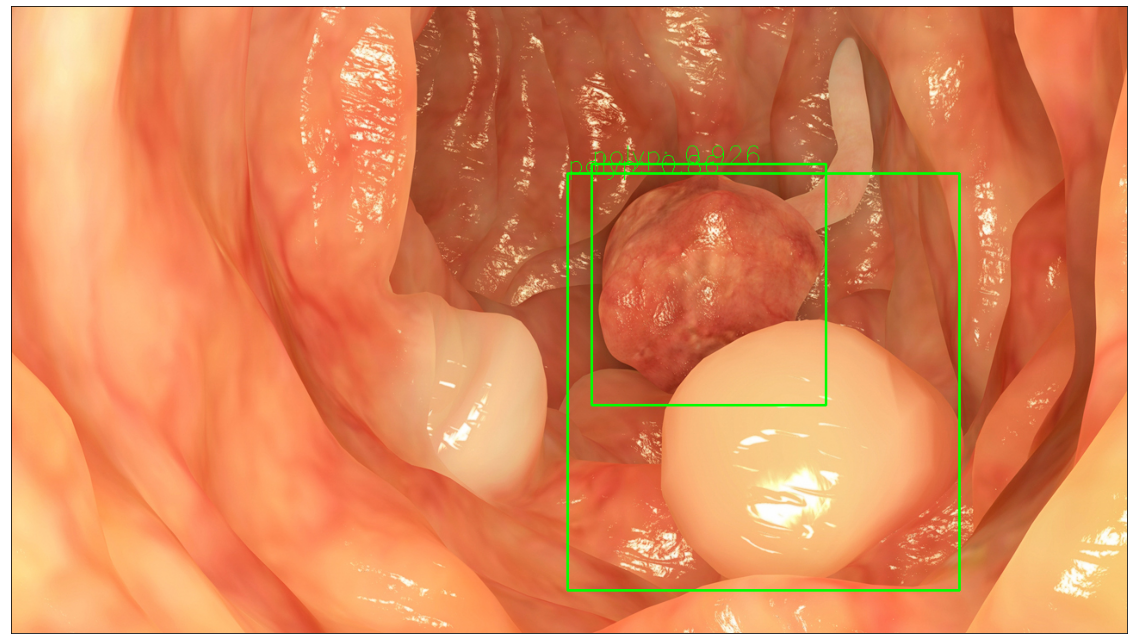

In [54]:
detect_object('data\Test\Colonic_polyps-1296x728-gallery_slide2.jpg', confidence=0.8)

[{'boxes': tensor([[ 172.0407,  130.7158,  945.2261,  743.6765],
        [ 398.7996,  248.6064,  908.9803,  684.6638],
        [ 745.4826,  574.6212,  929.2703,  721.0729],
        [  20.2148,    0.0000, 1064.6838,  919.7052],
        [ 391.1628,  321.4008,  672.7991,  694.5453],
        [ 566.6227,  253.7563,  878.5620,  570.7101],
        [  75.7905,    0.0000,  970.1581,  490.1346]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7707, 0.5572, 0.4763, 0.2547, 0.0876, 0.0777, 0.0667],
       device='cuda:0', grad_fn=<IndexBackward0>)}]
['polyp', 'polyp', 'polyp', 'polyp', 'polyp', 'polyp', 'polyp']
[[(172.04068, 130.7158), (945.2261, 743.6765)], [(398.79962, 248.60635), (908.9803, 684.66376)], [(745.4826, 574.6212), (929.27026, 721.0729)], [(20.2148, 0.0), (1064.6838, 919.7052)], [(391.1628, 321.40082), (672.79913, 694.54535)], [(566.62274, 253.75635), (878.56195, 570.71014)], [(75.79049, 0.0), (970.158

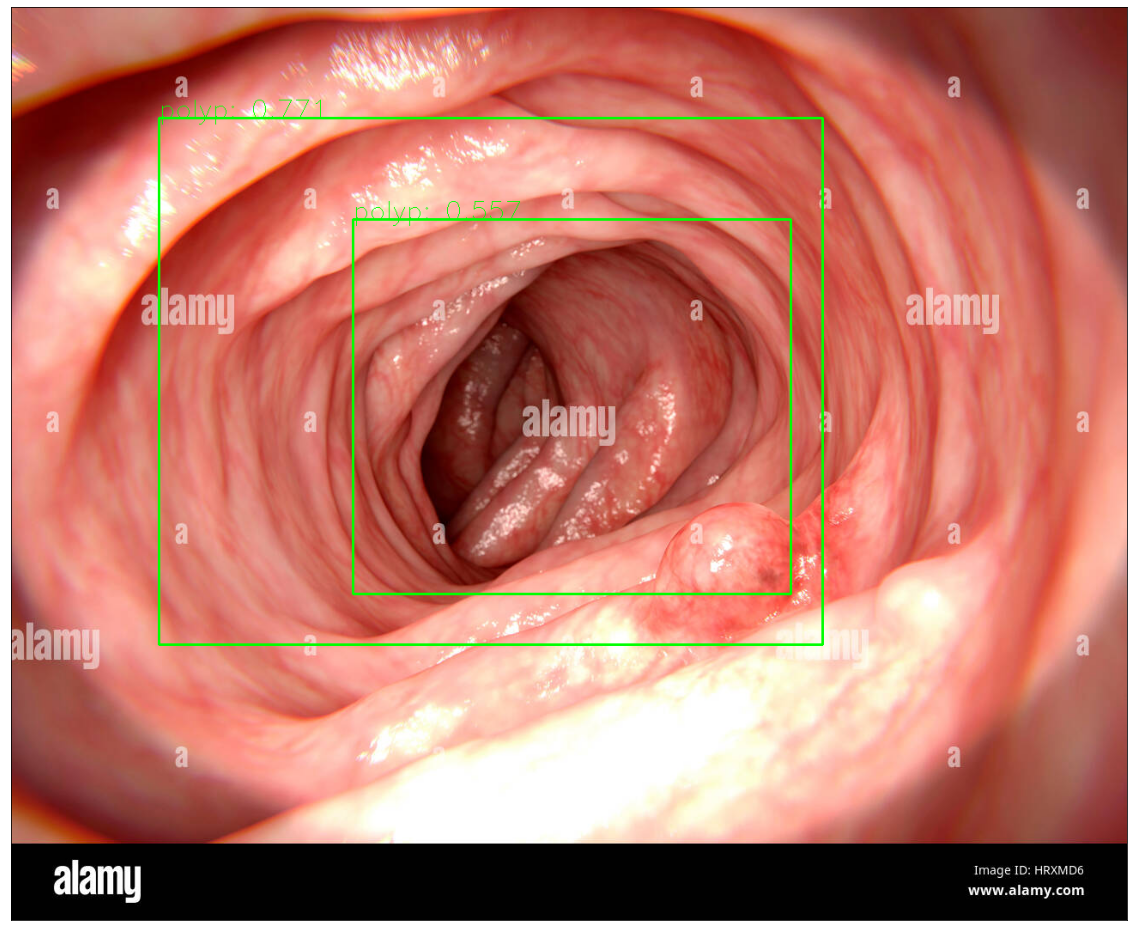

In [58]:
detect_object('data\Test\computer-illustration-of-an-adenomatous-polyp-in-the-intestine-polyps-HRXMD6.jpg', confidence=0.5)

[{'boxes': tensor([[ 603.1503,  187.3622,  804.6448,  420.2955],
        [ 147.9018,  220.0488,  236.8342,  337.6201],
        [ 605.6309,  190.2645,  963.1005,  501.7867],
        [ 845.5931,  351.6838,  975.0674,  478.3720],
        [ 563.2972,    1.2641, 1021.7067,  508.9968],
        [ 131.1774,  158.8634,  243.1544,  348.8153],
        [   0.0000,    0.0000,  491.8115,  513.0624],
        [ 156.0362,  345.4518,  263.8566,  430.6312],
        [  93.7386,  102.3625,  276.7321,  340.2503],
        [ 770.2169,  301.2267,  993.4567,  494.8961]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9577, 0.9349, 0.4015, 0.2803, 0.1825, 0.1815, 0.1454, 0.1179, 0.1074,
        0.0651], device='cuda:0', grad_fn=<IndexBackward0>)}]
['polyp', 'polyp', 'polyp', 'polyp', 'polyp', 'polyp', 'polyp', 'polyp', 'polyp', 'polyp']
[[(603.1503, 187.36218), (804.64484, 420.29547)], [(147.9018, 220.04877), (236.83415, 3

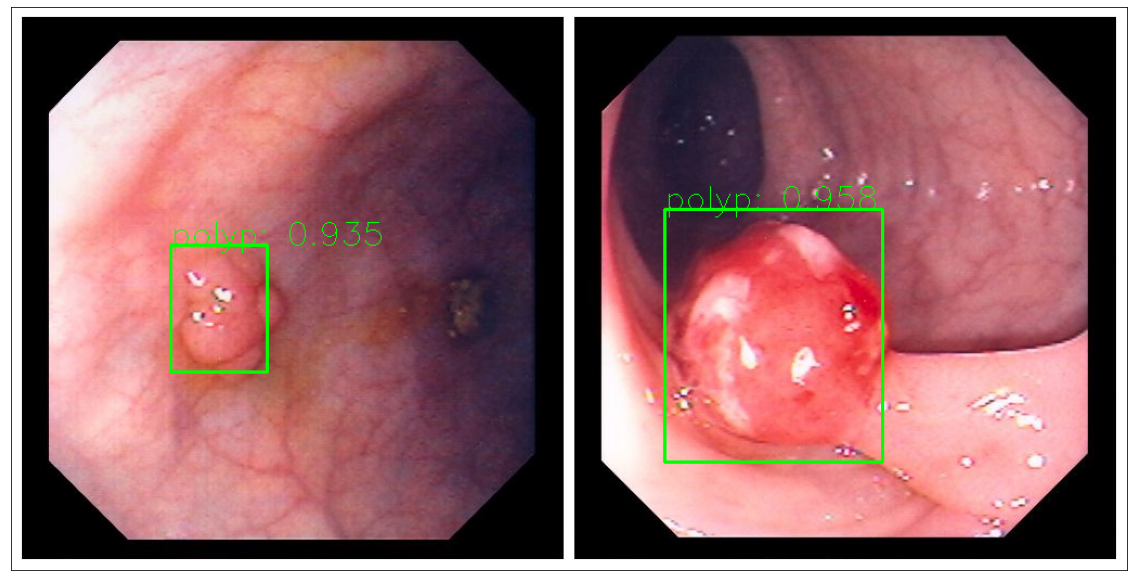

In [59]:
detect_object('data\Test\polyps_joined_high.jpg', confidence=0.8)

In [12]:

print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[0]
#transforms1 = get_transform(train=True)
#img, target = transforms1(img, target)
print(img.shape, '\n',target)

length of dataset =  200 

torch.Size([3, 528, 602]) 
 {'boxes': tensor([[298., 218., 423., 366.]]), 'labels': tensor([1]), 'area': tensor([18500.]), 'iscrowd': tensor([0]), 'image_id': tensor([914])}


In [ ]:
img, target = dataset[0]
plot_img_bbox(img, target)
